In [1]:
import akshare as ak 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if "PingFang" in f.name or "Heiti" in f.name]
plt.rcParams['font.sans-serif'] = ['Heiti TC']

import os 
from datetime import datetime
from tqdm import tqdm

### high roe, low price

In [22]:
def get_stock_codes(price_date, threshold, quadrant): 
    """
    quadrant == 1: high roe, high price (pe, pb, pr)
    quadrant == 2: low roe, high price (pe, pb, pr)
    quadrant == 3: low roe, low price (pe, pb, pr)
    quadrant == 4: high roe, low price (pe, pb, pr)
    """
    stock_values = []
    for stock_value_file in os.listdir(f"../data/processed/stock-valuation/{price_date}"): 
        stock_value = pd.read_csv(os.path.join(f"../data/processed/stock-valuation/{price_date}/", stock_value_file))
        stock_value['code'] = stock_value['code'].astype(int).astype(str).str.zfill(6)
        stock_values.append(stock_value.iloc[-1])
    stock_values = pd.DataFrame(stock_values, columns=stock_value.columns)
    pe_th_l = stock_values.query("pe_ttm > 0").pe_ttm.quantile(threshold)
    pe_th_h = stock_values.query("pe_ttm > 0").pe_ttm.quantile(1-threshold)
    pb_th_l = stock_values.query("pe_ttm > 0").pb_ttm.quantile(threshold)
    pb_th_h = stock_values.query("pe_ttm > 0").pb_ttm.quantile(1-threshold)
    pr_th_l = stock_values.query("pe_ttm > 0").pr_ttm.quantile(threshold)
    pr_th_h = stock_values.query("pe_ttm > 0").pr_ttm.quantile(1-threshold)
    roe_th_l = stock_values.query("pe_ttm > 0").roe_ttm.quantile(threshold)
    roe_th_h = stock_values.query("pe_ttm > 0").roe_ttm.quantile(1-threshold)
    
    if quadrant == 1: 
        stock_values_filtered = stock_values.query(f"(pe_ttm > {pe_th_h}) & (pb_ttm > {pb_th_h}) & (pr_ttm > {pr_th_h}) & (roe_ttm > {roe_th_h})")
    elif quadrant == 2: 
        stock_values_filtered = stock_values.query(f"(pe_ttm > {pe_th_h}) & (pb_ttm > {pb_th_h}) & (pr_ttm > {pr_th_h}) & (roe_ttm < {roe_th_l})")
    elif quadrant == 3:
        stock_values_filtered = stock_values.query(f"(pe_ttm < {pe_th_l}) & (pb_ttm < {pb_th_l}) & (pr_ttm < {pr_th_l}) & (roe_ttm < {roe_th_l})")
    elif quadrant == 4: 
        stock_values_filtered = stock_values.query(f"(pe_ttm < {pe_th_l}) & (pb_ttm < {pb_th_l}) & (pr_ttm < {pr_th_l}) & (roe_ttm > {roe_th_h})")
    print(f"pe_th_h: {pe_th_h:.2f} | pe_th_l: {pe_th_l:.2f} | " +\
          f"pb_th_h: {pb_th_h:.2f} | pb_th_l: {pb_th_l:.2f} | " +\
          f"pr_th_h: {pr_th_h:.2f} | pr_th_l: {pr_th_l:.2f} | " +\
          f"roe_th_h: {roe_th_h:.2f}, roe_th_l: {roe_th_l:.2f}")
    return stock_values_filtered.code.tolist()

In [20]:
def plot_stock_values(stock_codes, price_date):
    ob_stocks = stock_codes
    for stock_code in ob_stocks:
        stock_files = os.listdir(f"../data/processed/stock-valuation/{price_date}")
        ob_stock_file = [file for file in stock_files if stock_code in file][0]
        financial_price = pd.read_csv(os.path.join(f"../data/processed/stock-valuation/{price_date}", ob_stock_file))

        fig, axes = plt.subplots(2, 2, figsize=(12, 6))
        axes = axes.flatten()

        # pe ttm distribution
        sns.kdeplot(financial_price, x='pe_ttm', fill=True, color="#eeb908", ax=axes[0])
        
        # median pettm
        axes[0].axvline(x=financial_price['pe_ttm'].median(), color='blue', linestyle='--', label='median')
        # 25th percentile
        axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.25), color='blue', linestyle='--', label='25th percentile')
        # 75th percentile
        axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.75), color='blue', linestyle='--', label='75th percentile')
        
        # current pe ttm
        axes[0].axvline(x=financial_price.iloc[-1, -5], color='red', linestyle='--', label='current')
        axes[0].legend()

        # pb ttm distribution
        sns.kdeplot(financial_price, x='pb_ttm', fill=True, color="#eeb908", ax=axes[1])
        
        # median pbttm
        axes[1].axvline(x=financial_price['pb_ttm'].median(), color='blue', linestyle='--')
        # 25th percentile
        axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.25), color='blue', linestyle='--')
        # 75th percentile
        axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.75), color='blue', linestyle='--')
        # current pb ttm
        axes[1].axvline(x=financial_price.iloc[-1, -4], color='red', linestyle='--')

        # pr ttm distribution
        sns.kdeplot(financial_price, x='pr_ttm', fill=True, color="#eeb908", ax=axes[2])
        
        # median prttm
        axes[2].axvline(x=financial_price['pr_ttm'].median(), color='blue', linestyle='--')
        # 25th percentile
        axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.25), color='blue', linestyle='--')
        # 75th percentile
        axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.75), color='blue', linestyle='--')
        # current pr ttm
        axes[2].axvline(x=financial_price.iloc[-1, -3], color='red', linestyle='--')

        # roe ttm distribution
        sns.kdeplot(financial_price, x='roe_ttm', fill=True, color="#eeb908", ax=axes[3])
        
        # median roettm
        axes[3].axvline(x=financial_price['roe_ttm'].median(), color='blue', linestyle='--')
        # 25th percentile
        axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.25), color='blue', linestyle='--')
        # 75th percentile
        axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.75), color='blue', linestyle='--')
        # current roe ttm
        axes[3].axvline(x=financial_price.iloc[-1, -6], color='red', linestyle='--')
        
        stock_names = pd.read_csv("../data/input/stock_names_full.csv")
        stock_name = stock_names[stock_names['code'] == int(stock_code)]['name'].values[0]
        fig.suptitle(f"{stock_code} {stock_name} | pettm {financial_price.iloc[-1, -5]:<10.2f} | \
            pbttm {financial_price.iloc[-1, -4]:<10.2f} | prttm {financial_price.iloc[-1, -3]:<10.2f} | roettm {financial_price.iloc[-1, -6]:<10.2f}", 
            fontsize=10)
        plt.tight_layout()
        plt.show()

pe_th_h: 46.60 | pe_th_l: 15.95 | pb_th_h: 4.31 | pb_th_l: 1.40 | pr_th_h: 6.03 | pr_th_l: 1.20 | roe_th_h: 14.06, roe_th_l: 6.21


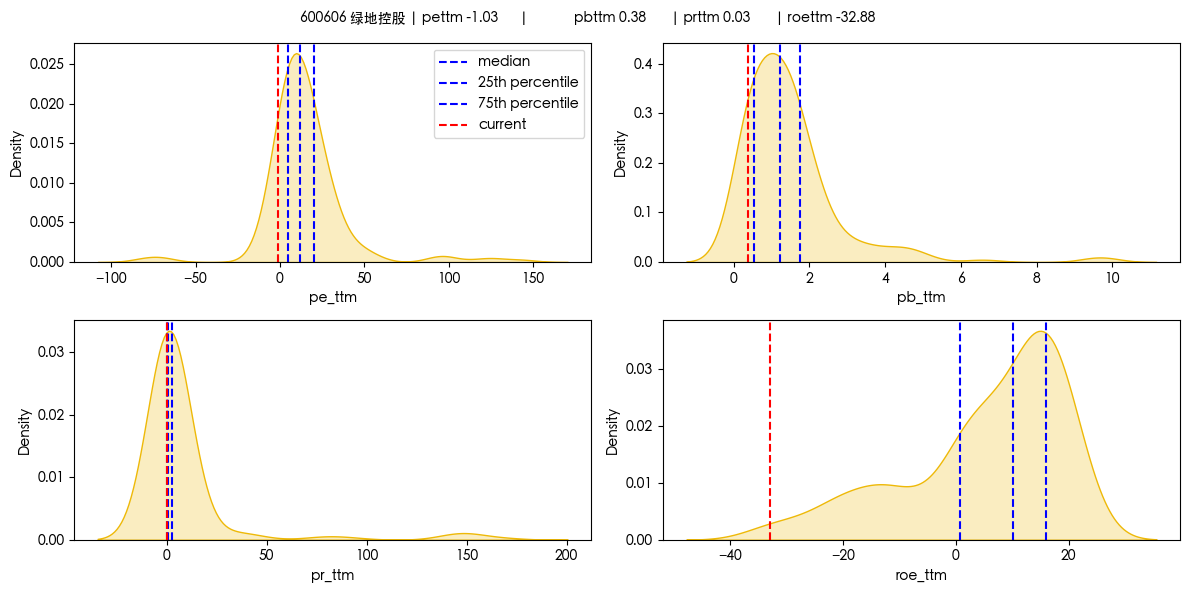

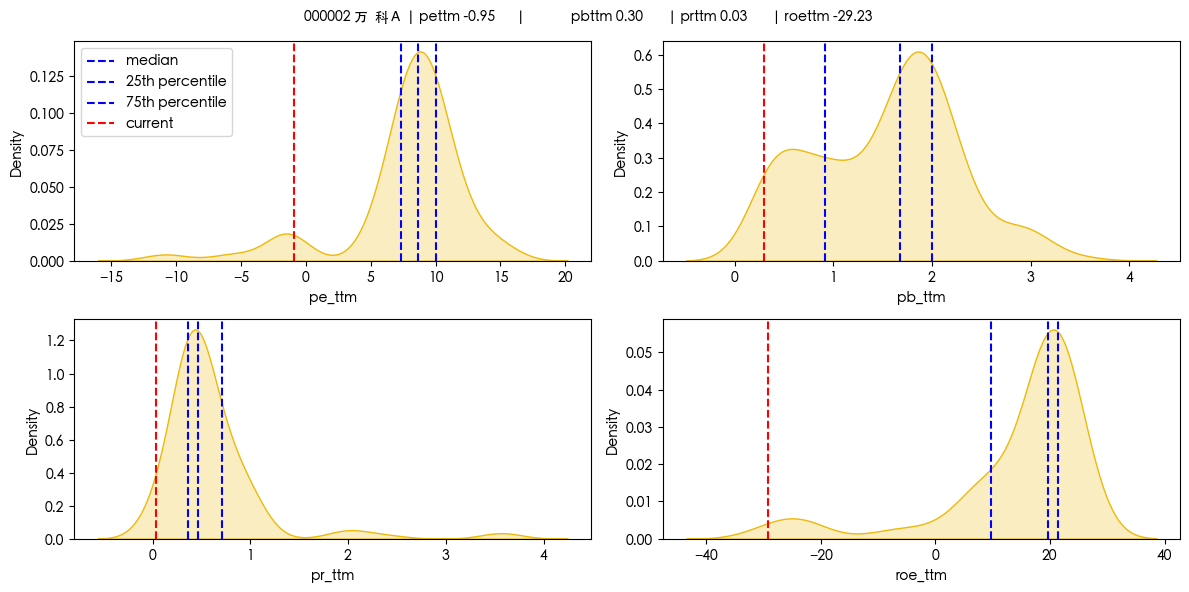

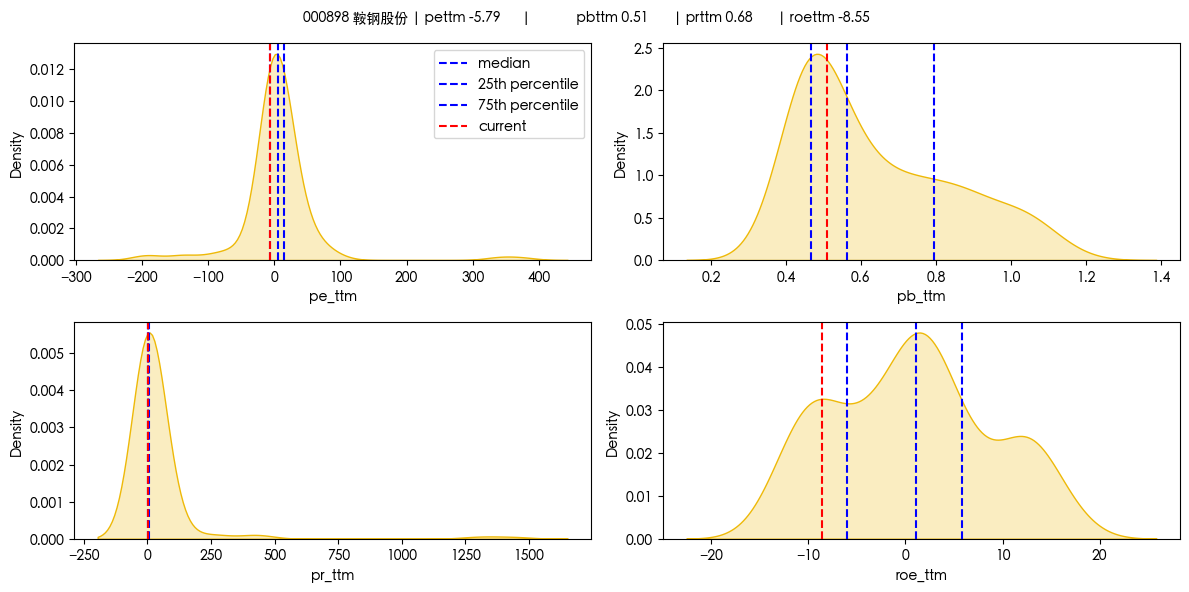

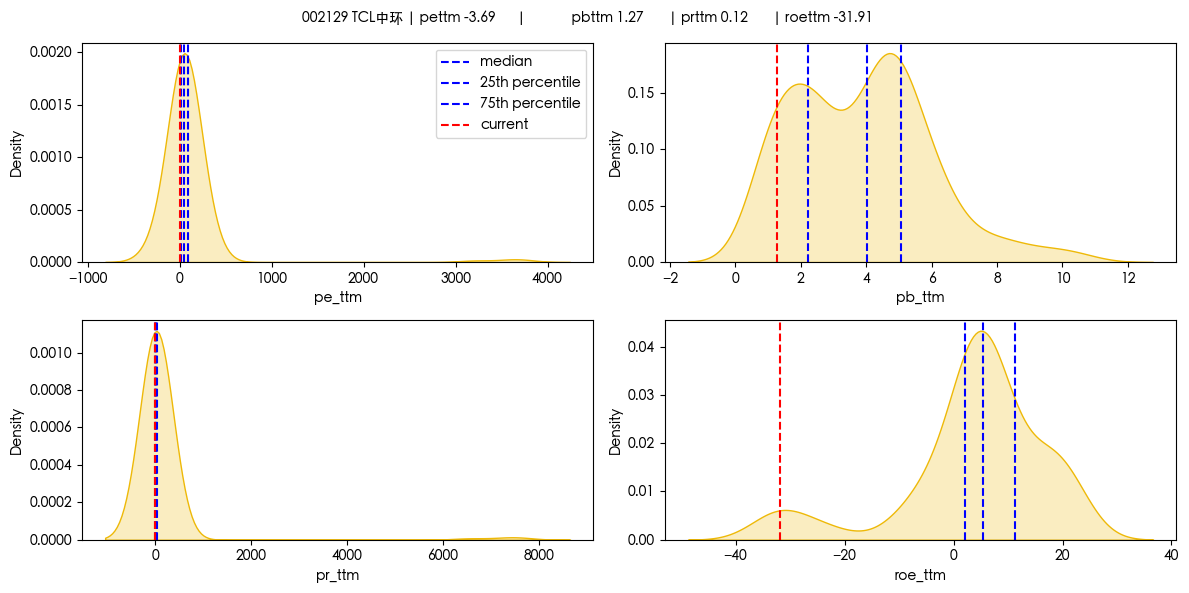

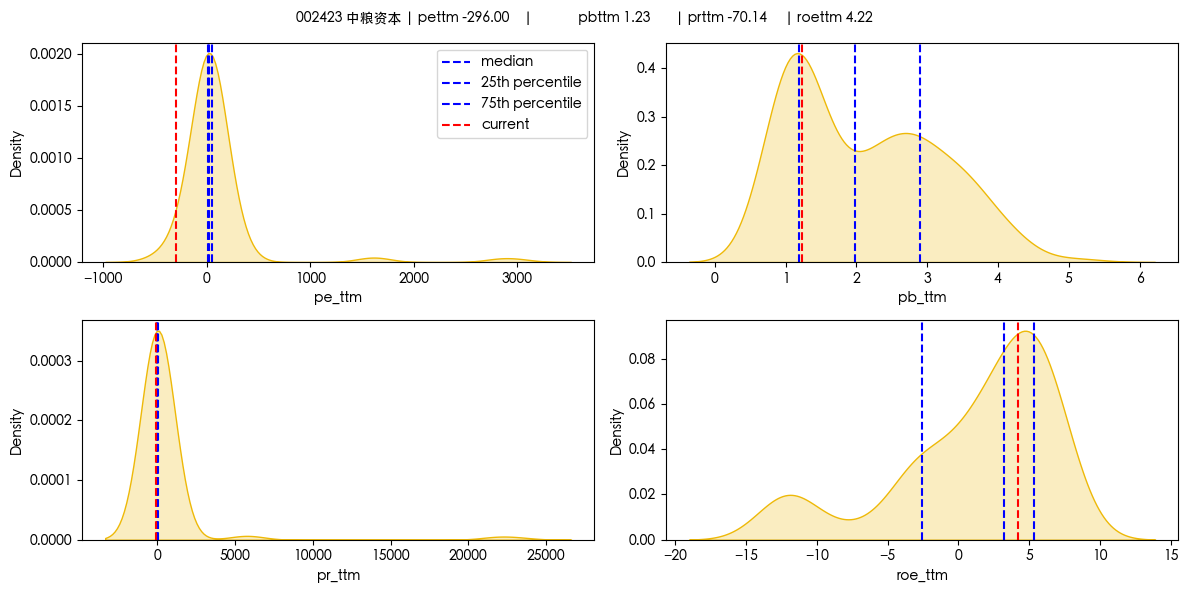

In [25]:
"""
quadrant == 1: high roe, high price (pe, pb, pr)
quadrant == 2: low roe, high price (pe, pb, pr)
quadrant == 3: low roe, low price (pe, pb, pr)
quadrant == 4: high roe, low price (pe, pb, pr)
"""

threshold = 0.26
price_date = "20251226"
quadrant = 3

stock_code = get_stock_codes(price_date, threshold, quadrant)
plot_stock_values(stock_code, price_date)